In [1]:
import os     
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import Activation,Flatten,Dense,Dropout
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
tf.__version__

'2.6.0'

In [2]:
classes = [ 'cats' , 'dogs' ]

In [4]:
idg=ImageDataGenerator(rescale=1./255,dtype = ('float32'),
                                   rotation_range=40,        #隨機旋轉0~40度
                                   width_shift_range=0.4,    #隨機水平偏移的幅度  參數0~1之間  隨機偏移距離0~圖片長*參數
                                   height_shift_range=0.4,   #隨機垂直偏移的幅度  參數0~1之間  隨機偏移距離0~圖片寬*參數
                                   shear_range=0.4,         #按比例平移
                                    fill_mode='nearest',
                                   validation_split=0.2,
                                   zoom_range=0.4,          #隨機縮放的幅度 參數0~1放大   大於1變小
                                   horizontal_flip=True)
idg2=ImageDataGenerator(rescale=1./255)

In [5]:
train_directory=idg.flow_from_directory(
    directory=os.path.join("./train"),
    target_size=(224, 224),
    classes=classes,
    batch_size=32,
    class_mode='categorical',
    subset='training')

Found 20000 images belonging to 2 classes.


In [6]:
validation_directory=idg.flow_from_directory(
    directory=os.path.join("./train"),
    target_size=(224, 224),
    classes=classes,
    batch_size=32,
    class_mode='categorical',
    subset='validation')

Found 5000 images belonging to 2 classes.


In [7]:
model = Sequential()

model.add(Conv2D(filters=16,
                 kernel_size=(3,3),
                 padding='same',
                 input_shape=(224,224,3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=16,
                 kernel_size=(3,3),
                 padding='same',
                 input_shape=(224,224,3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2,activation='softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dropout (Dropout)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 16)                8

In [8]:
adamm=Adam(lr=0.001)
model.compile(loss='binary_crossentropy',
              optimizer=adamm,metrics=['accuracy']) 

C:\Users\beng8\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [9]:
stop=EarlyStopping(monitor='val_loss', patience=5,verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    './model/',
    monitor='val_loss',
    save_best_only=True,
    verbose=0 ) 

In [11]:
fit_history=model.fit_generator(train_directory,
                                steps_per_epoch=100,
                                epochs=20,
                                validation_data=validation_directory,
                                validation_steps=20,
                                callbacks=[stop,checkpoint]) 

ImportError: Image transformations require SciPy. Install SciPy.

In [12]:
model = load_model('./model/')

In [13]:
import matplotlib.pyplot as plt
def show_train_history(train_history,train_acc,test_acc):
    plt.plot(train_history.history[train_acc])
    plt.plot(train_history.history[test_acc])
    plt.title('Train History')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [14]:
show_train_history(fit_history,'accuracy','val_accuracy')

NameError: name 'fit_history' is not defined

In [15]:
show_train_history(fit_history,'loss','val_loss')

NameError: name 'fit_history' is not defined

In [16]:
test_path = './test/test.csv'
df = pd.read_csv(test_path, sep=',', skiprows=1,  names=['id', 'label'])
df['id'] = df['id'].astype('str')

test_datagen = ImageDataGenerator(rescale=1/255.)

test_directory = test_datagen.flow_from_dataframe(df, './test/testtest',
                                                x_col='id', y_col='label',
                                                target_size=(224,224),
                                                interpolation='bicubic',
                                                class_mode=None,
                                                shuffle=False,
                                                batch_size=1)

Found 100 validated image filenames.


In [17]:
predict = model.predict_generator(test_directory,verbose=1)
predict[:10]

C:\Users\beng8\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


ImportError: Image transformations require SciPy. Install SciPy.

In [16]:
pred_max = np.argmax(predict, axis = 1)
print(len(pred_max))
pred_max[:10]

100


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [17]:
label_dict={0:"cats",1:"dogs"}

In [18]:
test_label = df['label']
print(label_dict)
pd.crosstab(test_label,pred_max,
            rownames=['label'],colnames=['predict'])

{0: 'cats', 1: 'dogs'}


predict,1
label,
0,49
1,51


In [19]:
def show_Predicted_Probability(i):
    print('label:',label_dict[test_label[i]],
          'predict:',label_dict[pred_max[i]])
    plt.figure(figsize=(2,2))
    plt.imshow(np.reshape(test_directory[i],(224, 224,3)))
    plt.show()
    for j in range(2):
        print(label_dict[j]+' Probability:%1.5f'%(predict[i][j]))

label: dogs predict: dogs


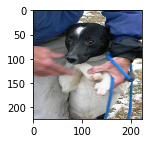

cats Probability:0.49675
dogs Probability:0.50325


In [20]:
show_Predicted_Probability(0)

In [21]:
df = pd.DataFrame({'label':test_label, 'predict':pred_max})
df[(df.label==0)&(df.predict==1)]

,label,predict
4,0,1
5,0,1
6,0,1
7,0,1
8,0,1
9,0,1
10,0,1
12,0,1
13,0,1
14,0,1


label: cats predict: dogs


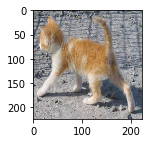

cats Probability:0.49675
dogs Probability:0.50325


In [22]:
show_Predicted_Probability(24)